## Members 
- Benedictus Kent RACHMAT
- Dana AUBAKIROVA
- Diego Andres TORRES GUARIN

## Data Format change

In the data preprocessing step we wanted to use ImageFolder method implemented in Pytorch. Therefore, we prepared the script for converting the current format of the data to the format where the 128x128 images will be stored in folders named by classes. 

In [1]:
import sys
# Load modules from /code folder so they can be
# easily imported from the notebook
sys.path.insert(0, '../code') 

In [2]:
from prepare_dataset import prepare_dataset_main

Running `prepare_dataset.py` will load the images from their original files and save them as images in a folder structured as:


```
new_data/
├─ train/
│  ├─ beach/
│  │  ├─ train_111.png
│  ├─ cloud/
│  │  ├─ train_231.png
│  ├─ .../
├─ valid-lab/
│  ├─ beach/
│  ├─ .../
├─ valid/
│  ├─ valid_0.png
│  ├─ .../
├─ test/
│  ├─ test_0.png
│  ├─ .../
```

In [3]:
# prepare_dataset_main()  # Uncomment if the data is not yet in image format at data/new_data

## Data Exploration

In this section, we analyze the probability distribution of the images per class in each dataset split (train, val, test) and compute the dataset statistics. Moreover, we apply PCA and explore the values for each channel (RGB) and visualize the major classes on Second PC vs First PC graph below. We also study the luminance and brightness of the images in each class. 

In [2]:
import os
import csv
import torch
import sklearn
import cv2
import platform
import colorsys
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from PIL import ImageStat
#from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy

In [5]:
sns.set_context('talk')

In [6]:
dotenv_path = Path("../public.env")
load_dotenv(dotenv_path=dotenv_path)

PUBLIC_DATA = os.getenv("PUBLIC_DATA")
NEW_DATA = os.getenv("NEW_DATA")

DATA_PATH = Path(PUBLIC_DATA)

DATA_NAME = "Areal"

DATA_SETS = ["train", "valid", "test"]
ALL_SETS = ["train", "valid-lab", "valid", "test"]

TORCH_MODEL = Path("torch/model")

Import the image using `datasets.ImageFolder` (Assuming that we have already run `prepare_dataset_main`)

In [6]:
train_folder = datasets.ImageFolder(NEW_DATA + "/train", transform=None)
train_data = list(train_folder)

val_folder = datasets.ImageFolder(NEW_DATA + "/valid-lab", transform=None)
val_data = list(val_folder)

shape_example = np.array(train_data[0][0])

print("Number of datapoints for training data:", len(train_data))
print("Number of datapoints for validation data:", len(val_data))
print("Shape of the images:", shape_example.shape)

Number of datapoints for training data: 4160
Number of datapoints for validation data: 1040
Shape of the images: (128, 128, 3)


Using the `train_folder` variable, we can extract the class names

In [7]:
idx_to_class_train = {v: k for k, v in train_folder.class_to_idx.items()}
classes_train = [idx_to_class_train[x] for x in train_folder.targets]

idx_to_class_val = {v: k for k, v in val_folder.class_to_idx.items()}
classes_val = [idx_to_class_val[x] for x in val_folder.targets]

df_label = pd.DataFrame(
    list(train_folder.class_to_idx.items()), columns=["labels", "code"]
)
print(df_label.to_string(index=False))

   labels  code
    beach     0
chaparral     1
    cloud     2
   desert     3
   forest     4
   island     5
     lake     6
   meadow     7
 mountain     8
    river     9
      sea    10
 snowberg    11
  wetland    12


Using `pandas` we could plot how many pictures we have for each label, we can conclude that chaparral has the most data among all.

In [8]:
class_counts = pd.Series(classes_train).value_counts()
class_counts_val = pd.Series(classes_val).value_counts()
concat_classes = pd.concat(
    [class_counts, class_counts_val], axis=1, keys=["train", "validation"]
)
concat_classes

,train,validation
chaparral,330,70
desert,327,73
wetland,324,76
lake,322,78
snowberg,322,78
meadow,320,80
river,320,80
forest,319,81
island,319,81
sea,319,81


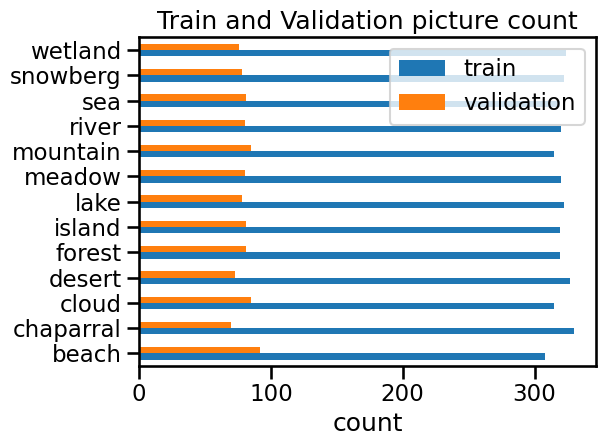

In [17]:
df = pd.DataFrame({"train": class_counts, "validation": class_counts_val})
ax = df.plot.barh()
plt.title("Train and Validation picture count")
plt.xlabel("count")
plt.tight_layout()
plt.savefig("../data/figures/label_counts.png")
plt.show()

We could also calculate the probability distribution of each label.  

In [18]:
training_prob = class_counts / class_counts.sum()
validation_prob = class_counts_val / class_counts_val.sum()
concat_prob = pd.concat(
    [training_prob, validation_prob], axis=1, keys=["train", "validation"]
)
concat_prob

,train,validation
chaparral,0.079327,0.067308
desert,0.078606,0.070192
wetland,0.077885,0.073077
lake,0.077404,0.075000
snowberg,0.077404,0.075000
meadow,0.076923,0.076923
river,0.076923,0.076923
forest,0.076683,0.077885
island,0.076683,0.077885
sea,0.076683,0.077885


In [25]:
def give_figure(label):
    ROWS, COLS = 4, 4
    indices = np.random.choice(
        np.where(np.array(classes_train) == label)[0], ROWS * COLS
    )
    fig, axes = plt.subplots(ROWS, COLS, figsize=(20, 20))
    for ax, idx in zip(axes.flatten(), indices):
        img = train_data[idx][0]
        ax.imshow(np.array(img))
        ax.axis('off')
        ax.set_title(f'Image: {idx}')

    return fig

To see the images, we change the parameter `label` to a particular label we want to visualize.

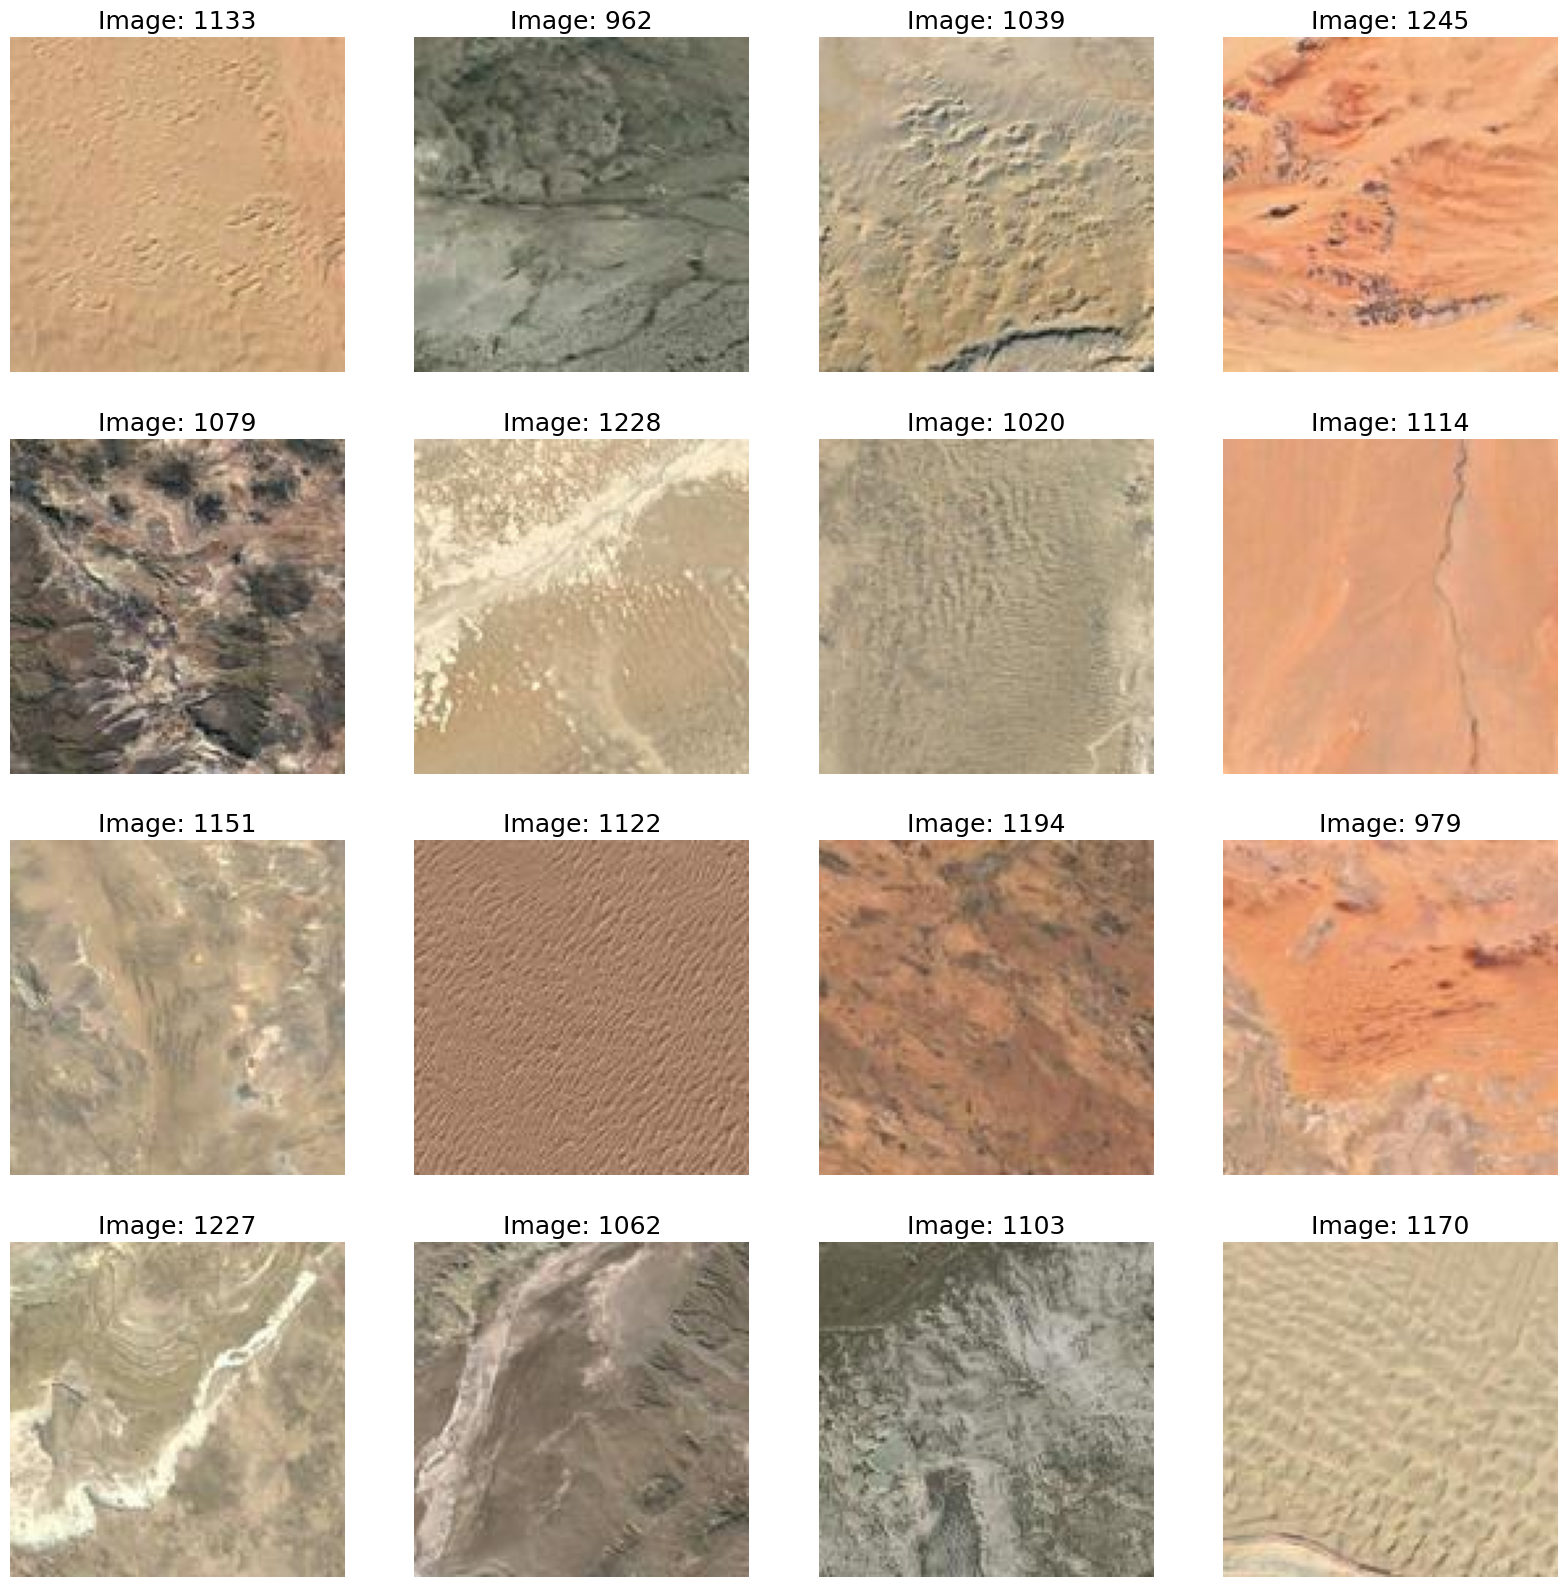

In [26]:
give_figure('desert');

For further exploratory data analysis, we analyze the RGB color model and plot the graph for the most prominent classes.

In [21]:
data_coords_train = pd.DataFrame(
    np.zeros((len(train_data), 4)), columns=list("RGB") + ["label"]
)
for n, (img, label) in enumerate(train_data):
    data_coords_train.iloc[n, :3] = np.array(img).mean(axis=(0, 1))
    data_coords_train.iloc[n, 3] = idx_to_class_train[label]

data_coords_train

,R,G,B,label
0,121.233643,144.952515,122.415894,beach
1,132.344788,139.552551,129.149719,beach
2,141.629639,150.961548,138.173950,beach
3,91.528687,98.197632,95.409363,beach
4,122.109253,139.947998,139.831299,beach
...,...,...,...,...
4155,63.124084,86.420410,58.049927,wetland
4156,64.196411,68.888367,55.825623,wetland
4157,48.039917,57.498718,50.928833,wetland
4158,41.097473,45.401489,31.682678,wetland


In [27]:
data_coords_val = pd.DataFrame(
    np.zeros((len(val_data), 4)), columns=list("RGB") + ["label"]
)
for n, (img, label) in enumerate(val_data):
    data_coords_val.iloc[n, :3] = np.array(img).mean(axis=(0, 1))
    data_coords_val.iloc[n, 3] = idx_to_class_val[label]

data_coords_val

,R,G,B,label
0,77.299133,97.377930,109.609924,beach
1,152.184021,149.910400,128.179199,beach
2,122.209839,120.249939,107.148376,beach
3,54.154846,71.564209,74.980469,beach
4,149.187439,138.041443,115.211792,beach
...,...,...,...,...
1035,52.962402,60.987610,44.388855,wetland
1036,56.109009,67.741394,52.346008,wetland
1037,78.011658,82.090759,68.736816,wetland
1038,54.763123,61.569885,43.713684,wetland


In [28]:
pca = PCA(2)
data_coords_train[list("rgb")] = data_coords_train[list("RGB")] / np.sqrt(
    np.sum(np.square(data_coords_train[list("RGB")]), axis=1).values.reshape(-1, 1)
)
data_coords_val[list("rgb")] = data_coords_val[list("RGB")] / np.sqrt(
    np.sum(np.square(data_coords_val[list("RGB")]), axis=1).values.reshape(-1, 1)
)

transformed_coords_train = pca.fit_transform(data_coords_train[list("rgb")])
transformed_coords_val = pca.transform(data_coords_val[list("rgb")])

data_coords_train[list("xy")] = transformed_coords_train
data_coords_val[list("xy")] = transformed_coords_val

red, green, blue = pca.transform(np.identity(3))

/home/diego/miniconda3/envs/HoMLChallenge/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


/tmp/ipykernel_9511/3614440482.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['label'] = plot_data['label'].str.capitalize()


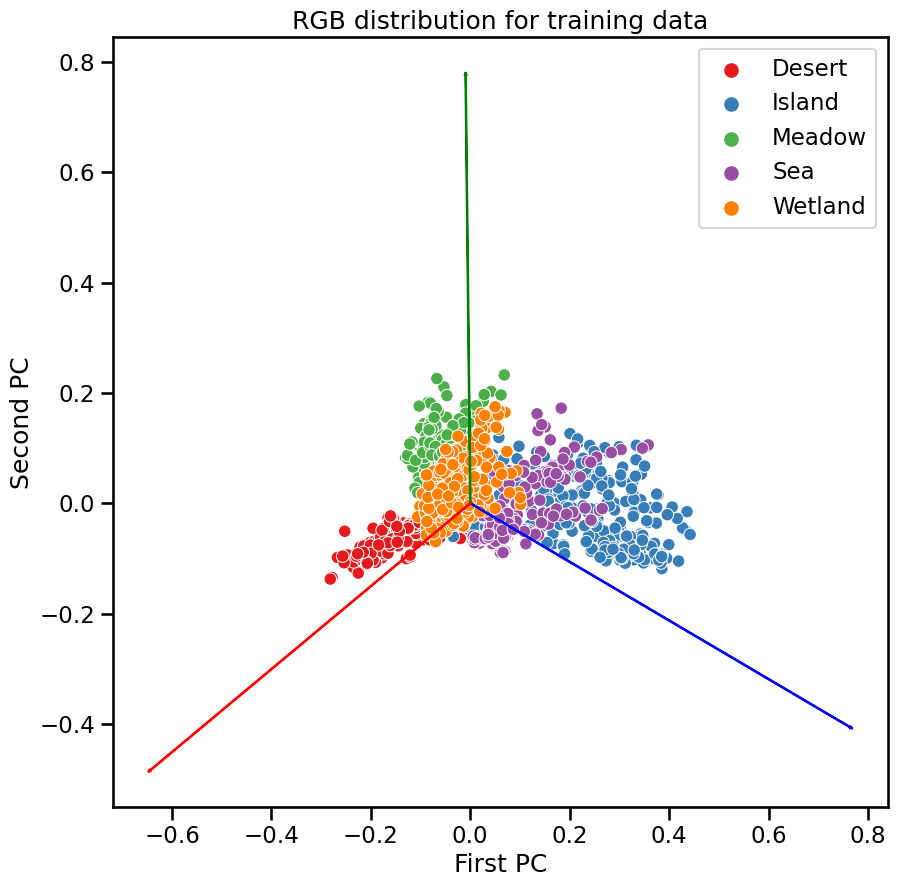

In [29]:
# training data
CHOSEN_CLASSES = ["desert", "island", "wetland", "sea", "meadow"]
plot_data = data_coords_train[data_coords_train["label"].isin(CHOSEN_CLASSES)]
plot_data["label"] = plot_data["label"].str.capitalize()
plt.figure(figsize=(10, 10))
sns.scatterplot(x="x", y="y", hue="label", data=plot_data, palette="Set1")
plt.arrow(0, 0, *blue, color="blue")
plt.arrow(0, 0, *green, color="green")
plt.arrow(0, 0, *red, color="red")
plt.title("RGB distribution for training data")
plt.xlabel("First PC")
plt.ylabel("Second PC")
plt.legend()
plt.savefig("../data/figures/pca_rgb.png")

/tmp/ipykernel_9511/2717237057.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['label'] = plot_data['label'].str.capitalize()


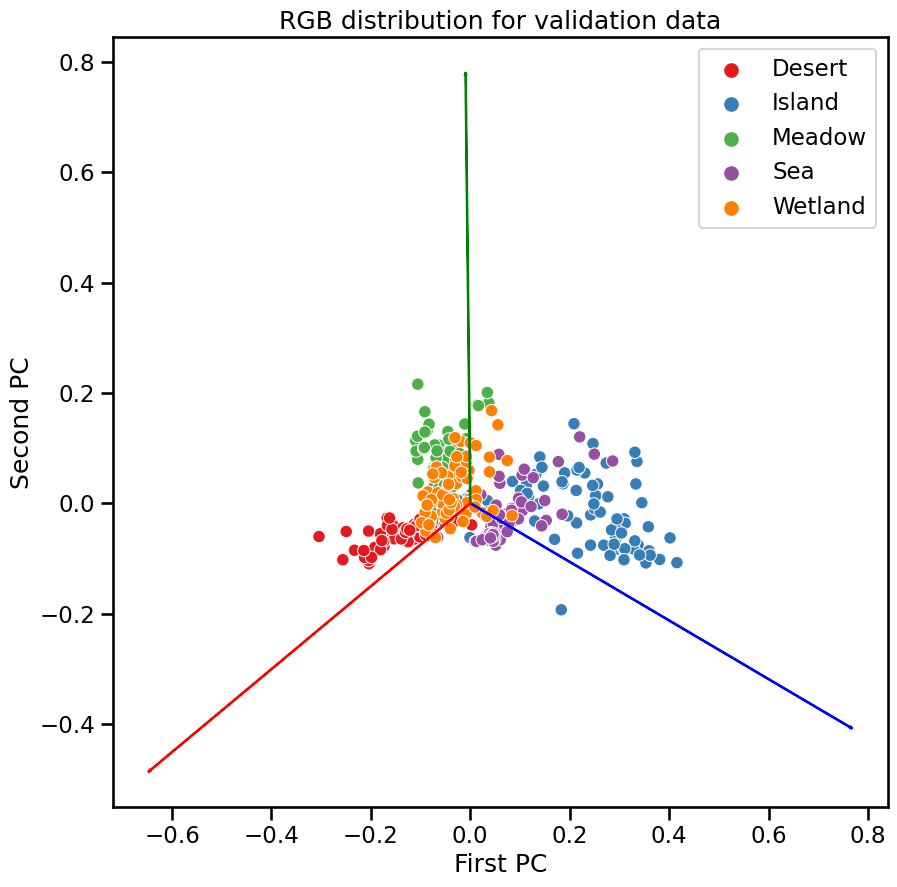

In [35]:
# validation data
plt.figure(figsize=(10, 10))
plot_data = data_coords_val[data_coords_val["label"].isin(CHOSEN_CLASSES)]
plot_data["label"] = plot_data["label"].str.capitalize()
sns.scatterplot(x="x", y="y", hue="label", data=plot_data, palette="Set1")
plt.arrow(0, 0, *blue, color="blue")
plt.arrow(0, 0, *green, color="green")
plt.arrow(0, 0, *red, color="red")
plt.title("RGB distribution for validation data")
plt.xlabel("First PC")
plt.ylabel("Second PC")
plt.legend()
plt.show()

Below, we analyze the brightness of the images per each class. We wanted to know which of the classes has the lower/higher brightness level and how it affects the model predictions.

In [36]:
BRIGHTNESS_VECTOR = np.array([0.2126, 0.7152, 0.0722])

In [37]:
data_coords_train["brightness"] = (
    data_coords_train[list("RGB")] @ BRIGHTNESS_VECTOR / 255
)

In [38]:
data_coords_val["brightness"] = data_coords_val[list("RGB")] @ BRIGHTNESS_VECTOR / 255

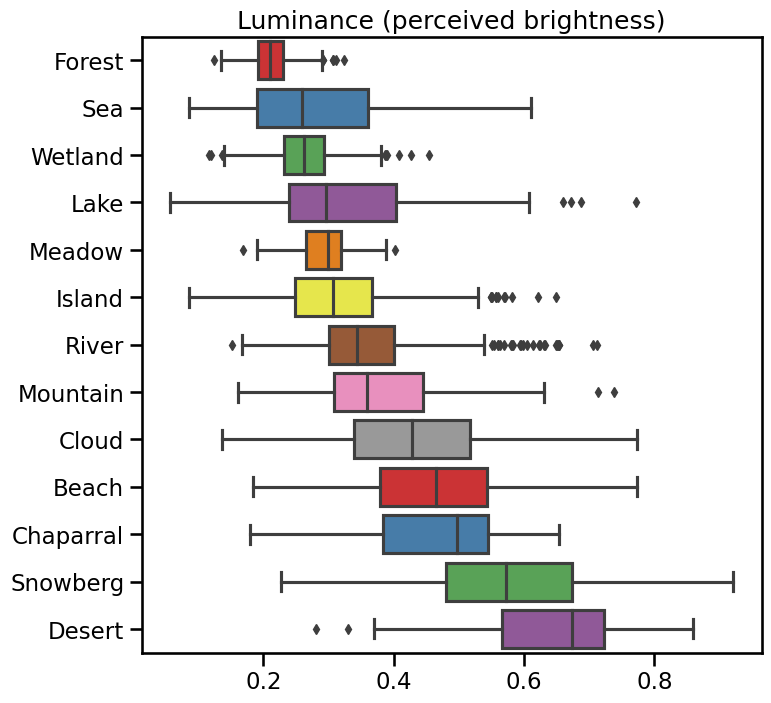

In [39]:
plot_data = data_coords_train[["label", "brightness"]].copy()
plot_data["label"] = plot_data["label"].str.capitalize()
order = plot_data.groupby("label")["brightness"].median().sort_values().index.tolist()
plt.figure(figsize=(8, 8))
sns.boxplot(y="label", x="brightness", data=plot_data, order=order, palette="Set1")
plt.ylabel("")
plt.xlabel("")
plt.title("Luminance (perceived brightness)")
plt.savefig("../data/figures/luminance.png")

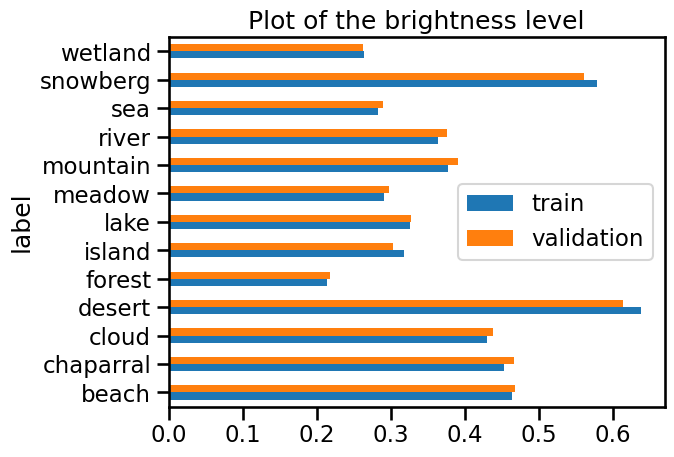

In [41]:
df = pd.DataFrame(
    {
        "train": data_coords_train.groupby("label")["brightness"].mean(),
        "validation": data_coords_val.groupby("label")["brightness"].mean(),
    }
)
ax = df.plot.barh()
plt.title("Plot of the brightness level")
plt.show()

**Results:** According to the data exploratory analysis:
1. The dataset is balanced, as we have more or less even distribution of images per class in each dataset split;
2. Chaparral class has the largest number of data;
3. The RGB values are distributed more evenly for 5 major classes: Desert, Island, Meadow, Sea, Wetland;
4. The Forest has the lowest brightness and the Desert, the Snowberg classes have the highest brightness level.

We investigate the impact of these main observations in further analysis. 

## Training

### CNN: Model from scratch

CNNs are currently dominating method in Image Classifiaction due to its ability to take advantage of inherent properties of images. In this regard, we wanted to use CNNs to solve this task and to address the following points:
1. Learn how to build our own model
2. Analyze the impact of convolutional layers and activation functions 
3. Extract and visualize the feature maps
4. Identify the number of layers sufficient to achieve the reasonable accuracy 

We build the model from scratch using 3 convolutional layers with kernel sizes having dimensions of 3x3,5x5,7x7. We used Batch Normalization and the activation (ReLU) after each convolution and 2 FC layers. The model can be found in the custom_model.py script. The model architecture is given in the diagram below:

![The network architecture](../diag.png)

We used Optuna for hyperparameter tuning and identified the optimal values for input and output channels in each layer, the number of neurons in FC layers, and the learning rate. The best hyperparameters are recorded in data/best_params.json. 

The training of the model from scratch can be done by running the script `train_custom.py`. You can either use the best hyperparameters available at `data/best_params.json`, or use your own by changing the last  part of the script. 

To find a good set of hyperparameters for the model from scratch, you can run the script `hyper_tuning.py`. Let's train the model with 6 epochs just to show how the process looks like. We trained this model for 

In [1]:
!python ../code/train_custom.py

EPOCH: 1
2.506885290145874
2.348251118324697
2.201225457959481
2.1867055247405593
1.7916098622906118
1.8138790369061393
1.6288173031294746
1.7213312288349925
1.5180400744915072
1.4895758800107521
1.448923839156477
1.802577977081358
1.4825854264245333
1.4245955585465753
1.5791167324291528
1.2796959091507119
1.3842177787261396
1.3405255395141853
1.49041156729974
1.2721114908806914
1.146091794435551
1.3551892181620393
1.022210236070327
1.4451991947093026
1.3375426546584737
1.3687152877698199
Train loss: 1.2671183294180568
EPOCH: 2
1.5413570404052734
1.3182835986372083
1.2418302804396717
1.3438398793136164
1.5583181424255401
1.17526036501351
1.3081913978676352
1.168355102979774
1.2525420328559933
1.28069149709972
1.4169104192333881
1.3397696089323219
1.0508062109653427
1.1825591198154437
1.1835654543704535
1.0337253232299182
1.3311507888739287
1.3797093020003235
1.1093183530597521
1.4058577053727377
1.2048560633200862
1.3284436415661611
1.310295265978108
1.2964324230969122
1.29530031797427

### CNN: EfficientNet and Finetuning

We used pretrained weights of EfficientNet, by taking its classifier and changing FC layer such that it maps the 1280 input channels to the number of classes present in Aerial Image dataset, whiich is 13. The main reasons behind using transfer learning include:
1. Achieving higher classification accuracy
2. Compensating for the smaller dataset size (Efficient Net was trained on the dataset having 1000 categories)

Similar as before, it can be trained by running `train_custom.py` with the variable 
```python 
    EFF_NET = True
```

In [48]:
!python ../code/train_custom.py

EPOCH: 1
2.613163471221924
2.503306966740638
2.285999327065383
2.253417040016853
2.1229745741245827
2.0115028702998883
1.9649893903487619
1.9076776384282619
1.8042697363881324
1.6794464711035628
1.4748239618613235
1.3079630137753047
1.213391925906886
1.3227759120306928
0.9476138073482863
1.0342511695070695
0.9928648754296052
0.7793616074180403
0.9033924689300916
0.7152988738138236
0.6602392197650934
0.7593340802705888
0.6361505709868426
0.8581021009326196
0.42916512106879384
0.6611975444210598
Train loss: 0.6499113945781045
EPOCH: 2
0.5815098285675049
0.5212122353841551
0.6505678008109612
0.49950886197719085
0.44783546746890673
0.5042210757016545
0.4852277681871084
0.44212754589249803
0.3550580755887197
0.5406111836798195
0.263700273679605
0.5052824253769814
0.6799088054913768
0.5501532200950914
0.4684772734417715
0.5385053442679126
0.37516155288775554
0.29752889825075945
0.40135505216849243
0.597226432489867
0.2722430076891784
0.36046763652088654
0.1753756002813415
0.5974984939575108


### AutoML 
*(extracted from another notebook to show all results in the same place, the code won't work in this context)*

We wanted to see how AutoML will perform on the Image Classification task. So the main reasons were:
1. The dataset was provided in AutoML format
2. Try different ML frameworks at once 
3. Faster to deploy 
4. Compare ML-based classifiers to CNNs


In [50]:
from autosklearn import classification
print('autosklearn: %s' % autosklearn.__version__)  

autosklearn: 0.15.0


In [51]:
model = classification.AutoSklearnClassifier() # Loading Classifier 
model.fit(xps["train"], ys["train"])

[WARNING] [2022-12-05 13:46:34,787:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-05 13:46:36,137:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-05 13:46:38,056:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-05 13:46:39,294:Client-EnsembleBuilder] No runs were available to build an ensemble from


AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      per_run_time_limit=360)

After training the model, we can see the statistics using the method sprint_statistics(). We didn't included the training process, because it was trained in other notebook using resources provided by Google Colab. 

In [52]:
print(model.sprint_statistics()) 

auto-sklearn results:
  Dataset name: 33be9488-74a3-11ed-afb2-2fb43866b791
  Metric: accuracy
  Best validation score: 0.633649
  Number of target algorithm runs: 319
  Number of successful target algorithm runs: 229
  Number of crashed target algorithm runs: 39
  Number of target algorithms that exceeded the time limit: 2
  Number of target algorithms that exceeded the memory limit: 49



In [53]:
y_hat = model.predict(xps['valid-lab'])
acc = accuracy_score(ys['valid-lab'], y_hat)
print("Accuracy: %.3f" % acc)

Accuracy: 0.621


We can output the top best performing models using leaderboard() method. As ypu can see from the table, the best performing model is a random forest classifier with different ensemble weights. 

In [54]:
model.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
291,1,0.04,random_forest,0.366351,8.579438
245,2,0.10,random_forest,0.368536,8.651601
276,3,0.04,random_forest,0.368536,12.447568
188,4,0.08,random_forest,0.371449,9.916541
208,5,0.06,random_forest,0.372178,5.039222
285,6,0.04,random_forest,0.373634,8.641905
260,7,0.02,random_forest,0.374363,8.888058
101,8,0.14,random_forest,0.375091,9.510094
248,9,0.04,random_forest,0.375819,14.981305


**Results**:The accuracy for the AutoML based prediction is 62%, which is lower compared to the CNNs. This can be explained by the larger number of features, and the fact that simple ML models don’t consider spatial information of pixels in comparison to CNNs. Also, AutoML may not be optimized enough for Image Data. 

## Model Predictions

Now it is time to evaluate the model. In order to make predictions we prepared the script `predict.py`, It loads the valid 
and test data and uses the selected model to predict the labels. The predicted classes
will be saved at `results/Areal_test.predict`.

In [5]:
!python ../code/predict.py

Loading fine tuned effnet...
Predicting valid...
122it [00:03, 33.82it/s]
Predicting test...
122it [00:02, 46.64it/s]


## Model Error Analysis

In this section we analyse the model susceptibility to different perturbations. In other words, we record the change in accuracy with respect to the modified input using the augmentation techniques provided by Albumentations. We test the following methods: 

- **ColorJitter**: Randomly changes the brightness, contrast, and saturation of an image.
- **GaussNoise**: Apply gaussian noise to the input image.
- **ChannelShuffle**: Randomly rearrange channels of the input RGB image.
- **HueSaturationValue**: Randomly change hue, saturation and value of the input image.
- **ImageCompression**: Decreases image quality by Jpeg, WebP compression of an image.
- **Downscale**: Decreases image quality by downscaling and upscaling back.

More information on Albumentations can be found in the documentation https://albumentations.ai/docs/api_reference/augmentations/transforms/

### Evaluation on the original data

The function below computes the total accuracy over the whole valid set and the accuracy over each class using the built-in method MulticlassAccuracy from torchmetrics . And outputs the list of results, where the last value is total accuracy. 
$$ Accuracy = \sum_{i}^{N} 1(y_{i} = \hat{ y_{i}})$$
Where $y$ is a tensor of target values, and $\hat{y}$ is a tensor of predictions.

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [49]:
def test(data_loader, model, print_acc = True):
    model = model.to(device)
    model.eval()
    correct = 0
    preds = []
    gts = []
    #compute the accuracy per each class and returns the list
    metric = MulticlassAccuracy(num_classes=13, average=None) 
    
    for images, labels in data_loader:
        images, labels =  images.to(device), labels.to(device)
        output = model(images)
        pred = output.data.max(1)[1]
        preds.append(pred)
        gts.append(labels)
        #counts the number of correct predictions for each batch
        correct += pred.eq(labels.data).cpu().sum() 
    
    x = torch.reshape(torch.stack(preds,0), [-1,1])
    y = torch.reshape(torch.stack(gts,0), [-1,1])
    acc_per_class = metric(x.cpu(), y.data.cpu())
    results = list(100*np.array(acc_per_class))
    tot_acc = float(100. * correct / len(data_loader.dataset))
    results.append(tot_acc)
    if print_acc:
        print('\nValid set: Accuracy for the whole set : {}/{} ({:.2f}%)\n'.format(correct, len(data_loader.dataset),
            100. * correct / len(data_loader.dataset)))
    #returns the list of accuracies for each class and the total accuracy in the end of the list
    return results 

Record the accuracy of the model from scratch and pretrained model on the original data before applying augmentations

In [54]:
#Load the validation dataset
PATH_TO_VALID = '../data/new_data/valid-lab/'
valid_set = datasets.ImageFolder(root=PATH_TO_VALID, transform=transforms.ToTensor())
valid_data = DataLoader(valid_set, batch_size=16, shuffle=True, num_workers=2)

In [5]:
from predict import load_model_effnet, load_model_scratch
import albumentations as A

In [57]:
model_scratch = load_model_scratch()
model_effnet = load_model_effnet()

In [58]:
x_scratch = test(valid_data, model_scratch)


Valid set: Accuracy for the whole set : 866/1040 (83.27%)



In [59]:
x_effnet = test(valid_data, model_effnet)


Valid set: Accuracy for the whole set : 1005/1040 (96.63%)



### Modify the input

For this experiment we decided to use **Albumentations** as it provides wider range of augmentation methods in comparison to **PyTorch**. However, since the Albumentations accepts different input format incompatible to the pytorch method ImageFolder, below we create another class called **A_Transforms** where we can pass the method of augmentation and receive the correct input for ImageFolder. It will be useful further, when we automate the function for testing different methods. 

In [60]:
#implement the class for using the methods from Albumentations inside the ImageFolder method implemented in Pytorch 
class A_Transforms:
    def __init__(self, aug_type):
        self.transforms = aug_type

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

Let's try to apply Gaussian Noise and observe the change in accuracy.

In [251]:
#loading the validation set applying augmentations and setting the probability to 1
new_valid_set_noisy = datasets.ImageFolder(root=PATH_TO_VALID, transform = transforms.Compose([A_Transforms(A.GaussNoise(p=1)), transforms.ToTensor()]))
new_valid_loader_noisy = DataLoader(new_valid_set_noisy, batch_size=16, shuffle=True, num_workers=2)

In [340]:
#computing the accuracy of the model from scratch and effnet on the nosidy dataset
x_scratch_perturbed = test(new_valid_loader_noisy, model_scratch)
x_effnet_perturbed = test(new_valid_loader_noisy, model_effnet)


Valid set: Accuracy for the whole set : 860/1040 (82.69%)


Valid set: Accuracy for the whole set : 922/1040 (88.65%)



The decrease in ~0.5% and ~8.0% can be observed for the model trained from scratch and the model using the pretrained weights of EfficientNet respectively.

### Accuracy per class analysis

Now, let's try not only analyze the change in total accuracy. But use different augmentations decsribed above to observe the change in accuracies per each class. 

In [253]:
keys = [A.GaussNoise(p=1), A.ChannelShuffle(p=1), A.Downscale(p=1), A.HueSaturationValue(p=1), A.ColorJitter(p=1), A.ImageCompression(p=1)]
#create the list of keys, similar to the name of the augmentation methods below
names = ['GaussNoise', 'ChannelShuffle', 'Downscale', 'HueSaturationValue', 'ColorJitter', 'ImageCompression']
data_scratch = dict()
data_effnet = dict()
# iterating over different augmentations and computing the total and class accuracy for each type of the augmentation 
for augment_type, name in zip(keys,names):
    #create noisy validation set
    new_valid_set = datasets.ImageFolder(root=PATH_TO_VALID, transform = transforms.Compose([A_Transforms(augment_type), transforms.ToTensor()]))
    new_valid_loader = DataLoader(new_valid_set, batch_size=16, shuffle=True, num_workers=2)
    #compute accuracy for both models
    acc_1 = test(new_valid_loader, model_scratch) 
    acc_2 = test(new_valid_loader, model_effnet)
    # saving the results to the dict
    data_scratch[name] = acc_1
    data_effnet[name] = acc_2


Valid set: Accuracy for the whole set : 855/1040 (82.21%)


Valid set: Accuracy for the whole set : 929/1040 (89.33%)


Valid set: Accuracy for the whole set : 498/1040 (47.88%)


Valid set: Accuracy for the whole set : 854/1040 (82.12%)


Valid set: Accuracy for the whole set : 732/1040 (70.38%)


Valid set: Accuracy for the whole set : 423/1040 (40.67%)


Valid set: Accuracy for the whole set : 749/1040 (72.02%)


Valid set: Accuracy for the whole set : 967/1040 (92.98%)


Valid set: Accuracy for the whole set : 662/1040 (63.65%)


Valid set: Accuracy for the whole set : 922/1040 (88.65%)


Valid set: Accuracy for the whole set : 865/1040 (83.17%)


Valid set: Accuracy for the whole set : 1004/1040 (96.54%)



Create the dataframe for convenience using the class names from *valid_set.class_to_idx* and adding the column name for the total Accuracy

In [254]:
columns = list(valid_set.class_to_idx.keys())
columns.append('Total')

In [255]:
df_scratch = pd.DataFrame.from_dict(data_scratch, orient = 'index', columns = columns)
df_effnet = pd.DataFrame.from_dict(data_effnet, orient = 'index', columns = columns)

The table of the results for the model from scratch

In [256]:
df_scratch

,beach,chaparral,cloud,desert,forest,island,lake,meadow,mountain,river,sea,snowberg,wetland,Total
GaussNoise,77.173912,95.714279,87.058823,82.191780,85.185188,87.654320,71.794876,96.25,71.764709,65.000000,93.827156,97.435898,59.210526,82.211540
ChannelShuffle,48.913044,37.142857,83.529411,27.397261,62.962959,44.444447,35.897438,27.50,17.647058,23.750000,83.950615,87.179489,38.157894,47.884617
Downscale,70.652176,88.571426,54.117649,82.191780,12.345679,88.888893,69.230774,62.50,67.058823,56.250000,95.061729,98.717949,75.000000,70.384613
HueSaturationValue,66.304352,91.428574,83.529411,72.602737,61.728394,85.185188,56.410259,78.75,64.705887,41.250000,87.654320,92.307693,56.578945,72.019234
ColorJitter,56.521736,75.714287,78.823532,57.534248,64.197525,81.481483,53.846157,50.00,44.705883,32.500000,86.419754,88.461533,59.210526,63.653847
ImageCompression,80.434784,94.285713,90.588234,82.191780,82.716049,88.888893,76.923080,93.75,74.117645,60.000004,93.827156,94.871796,69.736847,83.173080


The table of results for the model trained using the pretrained weights of EfficientNet respectively.

In [257]:
df_effnet

,beach,chaparral,cloud,desert,forest,island,lake,meadow,mountain,river,sea,snowberg,wetland,Total
GaussNoise,96.739128,100.000000,100.000000,90.410957,92.592590,87.654320,92.307693,90.00,80.000000,82.50,95.061729,96.153847,56.578945,89.326920
ChannelShuffle,90.217392,97.142860,98.823532,67.123291,96.296295,83.950615,74.358978,75.00,47.058823,78.75,97.530869,96.153847,64.473686,82.115387
Downscale,67.391304,1.428571,96.470589,95.890411,20.987654,51.851852,20.512821,95.00,0.000000,3.75,39.506172,0.000000,28.947369,40.673077
HueSaturationValue,95.652176,98.571426,97.647057,87.671234,95.061729,88.888893,93.589745,92.50,88.235298,93.75,100.000000,94.871796,81.578949,92.980766
ColorJitter,90.217392,97.142860,96.470589,69.863014,97.530869,85.185188,92.307693,85.00,76.470589,86.25,98.765434,94.871796,81.578949,88.653847
ImageCompression,100.000000,100.000000,98.823532,91.780823,98.765434,92.592590,98.717949,96.25,92.941177,93.75,100.000000,98.717949,92.105263,96.538460


### Visualization

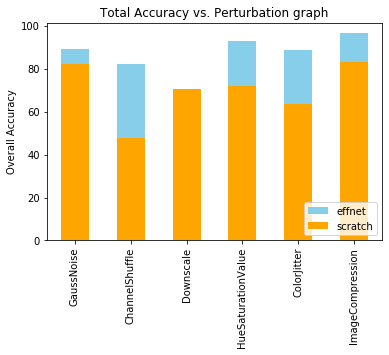

In [286]:
#make a total accuracy vs. augmentation type bar plot for both models
ax = df_effnet['Total'].plot(kind='bar', color = 'skyblue', label='effnet')
plt.title("Total Accuracy vs. Perturbation graph")
df_scratch['Total'].plot(kind='bar', color = 'orange', ax=ax, label = 'scratch')
plt.legend(loc='lower right')
plt.ylabel('Overall Accuracy')
plt.show()

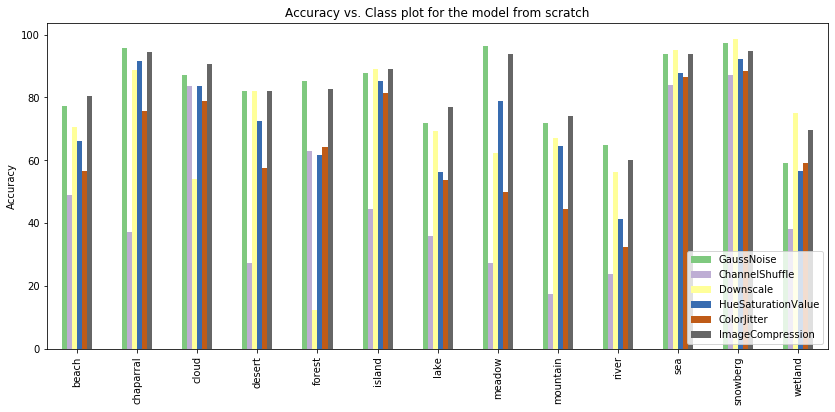

In [323]:
#transpose the dataframe, since we want to use classnames as x-axis
df_s_t = df_scratch[df_scratch.columns[:-1]].T
df_s_t.plot(kind='bar', figsize = (14, 6), cmap=plt.get_cmap('Accent'))
#make a accuracy vs. class bar plot for the model from scratch where the bars are the augmentation type
plt.legend(loc= 'lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Class plot for the model from scratch')
plt.show()

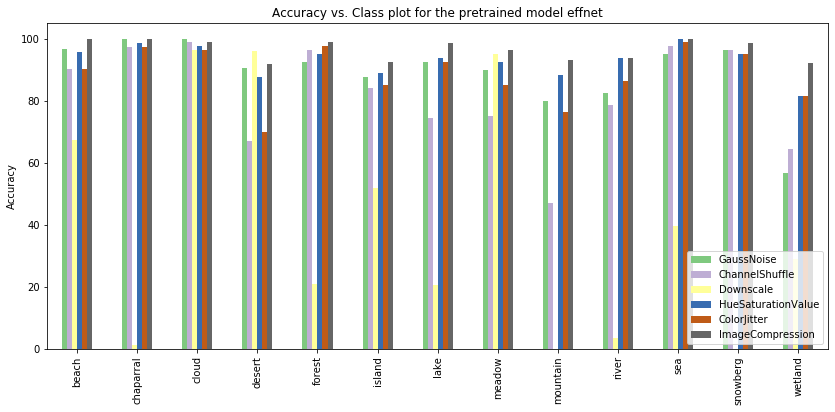

In [332]:
#transpose the dataframe, since we want to use classnames as x-axis
df_e_t = df_effnet[df_effnet.columns[:-1]].T
df_e_t.plot(kind='bar', figsize = (14, 6), cmap=plt.get_cmap('Accent'))
#make a accuracy vs. class bar plot for the effnet model where the bars are the augmentation type
plt.legend(loc= 'lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Class plot for the pretrained model effnet')
plt.show()

**Results:** According to the Model Error Analysis, we can infer several conclusions:
1. Since some of the augmentations were applied while training EfficientNet, it is more stable and robust than the model from scratch. 
2. Both models perform worse when Downscale is applied to the images.
3. Downscaling is more detrimental for EfficientNet, especially, for the River, Chaparral, and Wetland classes.
4. We cannot conclude that a particular class was hardest for both models from this analysis.

## Feature Maps

Now, let's look at CNN closer. One problem of deep neural networks is that they are essentially blackboxes. This means that it is very hard to know why they give a certain output from a certain input. In this case in particular, we would like to know why the model classified an image as a beach (for example).

For CNNs however, we can pass the image through the network right before the AvgPooling and the FullyConnected layers. This will give us a 'smaller image', which is the result of consecutively applying convolutions to the image. We will have one such image for each filter (in this case 44), and the high values will indicate that the filter is 'detecting' a particular feature. 

In [6]:
# We load the model from scratch
model = load_model_scratch()

Loading model from scratch...


In [65]:
model = model.to(device)

In [66]:
from train_custom import valid_data, valid_set

In [67]:
with torch.no_grad():
    # Select the first image from the validation set
    X, y = valid_set[0] 
    X = X.to(device).float()
    # We do the forward pass only through the convolutional layers
    features = model.features(X.unsqueeze(0)) 

(-0.5, 127.5, 127.5, -0.5)

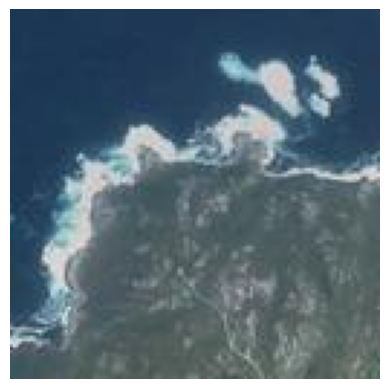

In [ ]:
plt.imshow(X.cpu().numpy().transpose(1,2,0))
plt.axis('off')

In [68]:
features = features[0].cpu().numpy() # We convert the features to numpy arrays

In [70]:
features = features/features.max() # We scale the feature maps so that all are between 0 and 1

With this figure we can interpret what the model is doing. For instance, filter number 17 seems to be detecting land. Since there is indeed a big portion on land in the image, the AvgPool layer will have a big value at position 37. The last two fully connected layers will use these kinds of features to distinguish between different classes. 

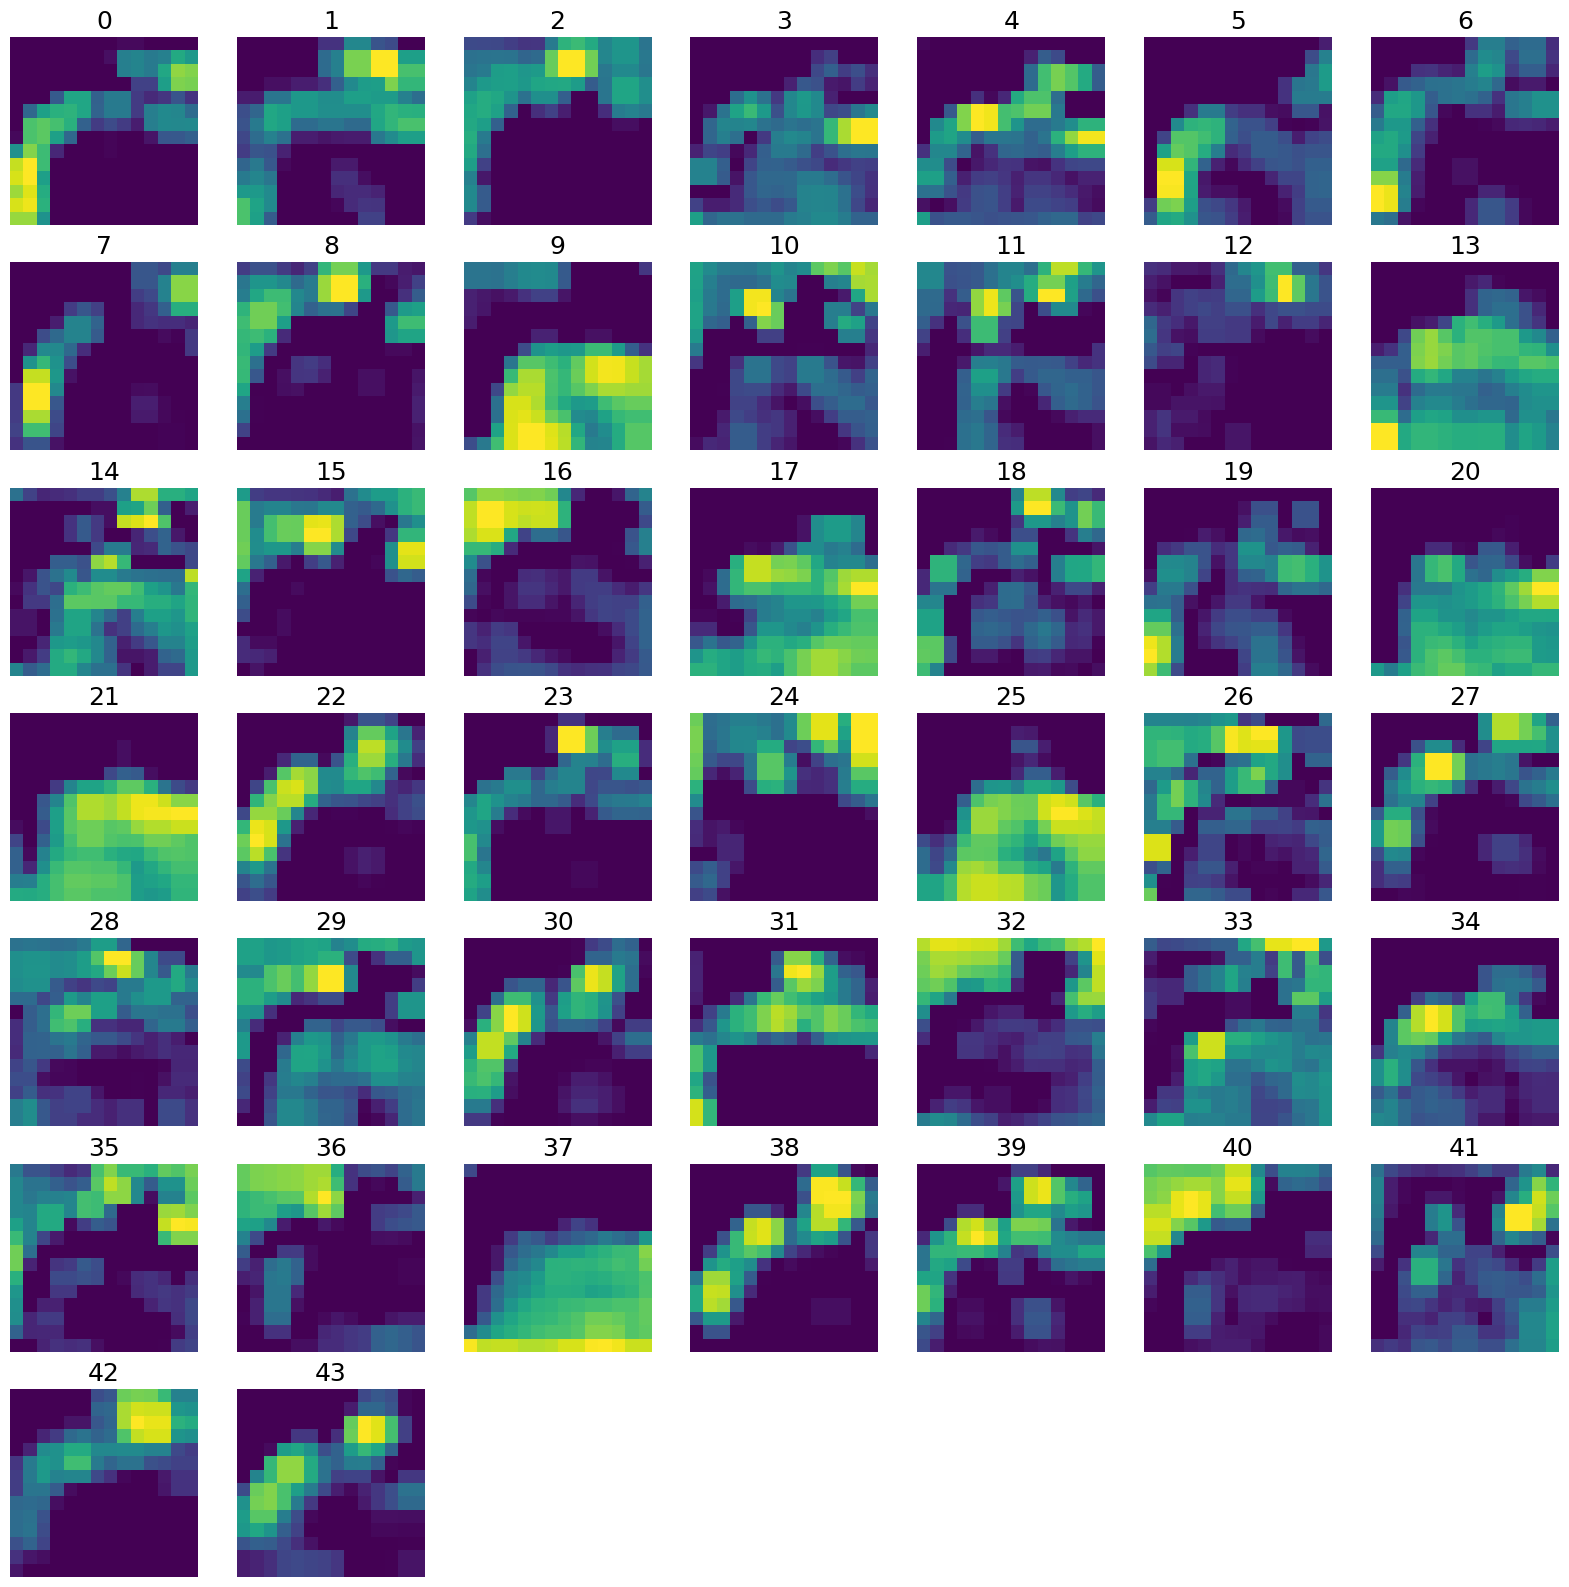

In [76]:
fig, axes = plt.subplots(7, 7, figsize=(20,20))
for n, (feature_map, ax) in enumerate(zip(features, axes.flatten())):
    ax.imshow(feature_map)
    ax.axis('off')
    ax.set_title(str(n))

for ax in axes.flatten()[-5:]:
    ax.axis('off')

**Results:** This analysis gives us a closer look on what is happening behind the scenes. And how the model is detecting particular features of the image, like corners, edges and etc. 